In [1]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers.core import Dropout

network = ResNet50(include_top=False)
input = Input(shape=(150, 150, 3))
x = network(input)
x = Flatten()(x)
x = Dense(1000, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=input, outputs=predictions)

resnet_model.summary()

Using TensorFlow backend.
C:\Users\th_k9\AppData\Local\Continuum\anaconda3\envs\Kimtae\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              51201000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 74,789,713
Trainable params: 74,736,593
Non-trainable params: 53,120
___________________________________________________________

In [2]:
import os 
import pickle

with open(os.path.join('../', '../', '300_pickle', 'whole', 'whole_3_train.p4'), mode='rb') as f:
    trData = pickle.load(f)
with open(os.path.join('../', '../', '300_pickle', 'whole', 'whole_3_test.p4'), mode='rb') as f:
    teData = pickle.load(f)
    
trimg, trlabel = trData['data'], trData['label']
teimg, telabel = teData['data'], teData['label']

trimg = trimg.astype('float32') / 255.0
teimg = teimg.astype('float32') / 255.0

trimg.shape, trlabel.shape, teimg.shape, telabel.shape

((15397, 150, 150, 3), (15397,), (10265, 150, 150, 3), (10265,))

In [3]:
import keras.backend as K

def recall(y_target, y_pred):
    y_target_yn = K.round(K.clip(y_target, 0, 1))
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) 

    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    count_true_positive_false_negative = K.sum(y_target_yn)

    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    return recall


def precision(y_target, y_pred):
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))
    y_target_yn = K.round(K.clip(y_target, 0, 1))

    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    count_true_positive_false_positive = K.sum(y_pred_yn)

    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    return precision

In [4]:
from keras import optimizers
optimizer = optimizers.Adam(lr=0.0001, decay=1e-5)
resnet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', precision, recall])

tr_img = trimg
tr_label = trlabel
te_img = teimg
te_label = telabel

data_num = len(tr_img)
varid_num = int(data_num * 0.7)

x_train = tr_img[:varid_num]
x_val = tr_img[varid_num:]
y_train = tr_label[:varid_num]
y_val = tr_label[varid_num:]

print('x_train : {}, x_val : {}'.format(len(x_train), len(x_val)))

history_ = resnet_model.fit(x_train, y_train, shuffle=True, epochs=15, batch_size=50, validation_data=(x_val, y_val))

from numpy import argmax
import csv 

print('')
scores = resnet_model.evaluate(te_img, te_label)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

resnet_model.save('../resnet50_patch_whole_3.h5')

x_train : 10777, x_val : 4620
Train on 10777 samples, validate on 4620 samples
Epoch 1/15
10777/10777 [==============================] - 77s 7ms/step - loss: 0.1639 - acc: 0.9573 - precision: 0.9503 - recall: 0.9480 - val_loss: 0.0353 - val_acc: 0.9872 - val_precision: 0.9966 - val_recall: 0.9703
Epoch 2/15
10777/10777 [==============================] - 58s 5ms/step - loss: 0.0218 - acc: 0.9942 - precision: 0.9920 - recall: 0.9933 - val_loss: 0.0309 - val_acc: 0.9929 - val_precision: 0.9853 - val_recall: 0.9970
Epoch 3/15
10777/10777 [==============================] - 58s 5ms/step - loss: 0.0203 - acc: 0.9950 - precision: 0.9929 - recall: 0.9948 - val_loss: 0.0584 - val_acc: 0.9820 - val_precision: 0.9972 - val_recall: 0.9551
Epoch 4/15
10777/10777 [==============================] - 58s 5ms/step - loss: 0.0243 - acc: 0.9930 - precision: 0.9902 - recall: 0.9924 - val_loss: 0.1410 - val_acc: 0.9558 - val_precision: 1.0000 - val_recall: 0.8870
Epoch 5/15
10777/10777 [=====================

0.24831647

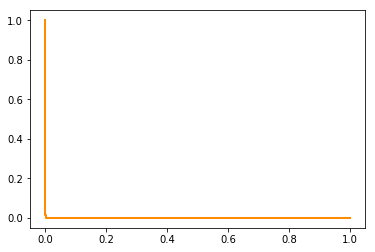

In [6]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

predict = resnet_model.predict(teimg)

fpr, tpr, threshold = roc_curve(telabel, predict, pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
roc_auc = auc(fpr, fnr)
#logging.info("EER threshold = {}".format(eer_threshold))

plt.figure()
lw = 2
plt.plot(fpr, fnr, color='darkorange', lw=lw, label='R')

eer_threshold